# Tutorial: E-Commerce Images

This tutorial will show you how to make products easier to find on an e-commerce platform by performing searches that understand and use both images and text.

With the help of the **OpenAI CLIP model** for understanding the data and creating embeddings from it, we will use the **Vantage** vector database for storing these embeddings in a collection, as well as for searching through your collections using both images and text.

Happy discovering!

## Step 1: Environment Setup

First, let's begin by installing the necessary prerequisite libraries.

In [3]:
! pip install pandas pyarrow -qU


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


To install the CLIP model, please follow the instructions provided in their official model [repository](https://github.com/openai/CLIP).

In [2]:
! pip install git+https://github.com/openai/CLIP.git -qU


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Finally, you can install the **Vantage** vector database by executing the following command.

In [4]:
! pip install vantage-sdk -qU


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


After importing the necessary libraries, we are now ready to proceed with the example!

In [5]:
import torch
import clip
from PIL import Image
import requests
import pandas as pd
from io import BytesIO

import vantage_sdk
from vantage_sdk import VantageClient

## Step 2: CLIP Model Preparation

We'll begin by instantiating the [CLIP model](https://openai.com/research/clip) (`model`), along with a torchvision transform callable (`preprocess`) that converts a PIL image into a tensor. This tensor can then be used as input for the instantiated model.

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## Mid-step: Helper Functions

In the upcoming cells, we'll develop several helper functions that will be used later during the data preprocessing and querying steps. A brief description will be provided above each function to explain its purpose.

In [7]:
"""
Creates a tuple containing embedding vectors for text and image data, created using the CLIP model. 
Text data is preprocessed/tokenized with the `clip.tokenize` method, 
while image data is preprocessed with the `preprocess` callable, which converts a PIL Image into a tensor.
The preprocessed data is encoded by the CLIP model to produce the embeddings.
"""

def create_clip_text_and_image_embeddings(text_to_embed: str, image_to_embed: Image) -> tuple[list[float], list[float]]:
    clip_preprocessed_text = clip.tokenize(text_to_embed, truncate=True).to(device)
    clip_preprocessed_image = preprocess(image_to_embed).unsqueeze(0).to(device)

    with torch.no_grad():
        clip_text_embedding = model.encode_text(clip_preprocessed_text).tolist()[0]
        clip_image_embedding = model.encode_image(clip_preprocessed_image).tolist()[0]

    return clip_text_embedding, clip_image_embedding

In [8]:
"""
Creates tuple of text and image records compatible with Vantage. 
The text record includes an embedding vector derived from the record's text.
The image record contains an embedding generated from the preprocessed image.
"""

def create_text_and_image_records(record_id: str, record_text: str, record_image_url: str, record_image: Image) -> tuple [dict, dict]:
    clip_text_embedding, clip_image_embedding = create_clip_text_and_image_embeddings(record_text, record_image)

    text_record = {
        "id": record_id + "_text",
        "embeddings": clip_text_embedding,
        "text": record_text
    }

    image_record = {
        "id": record_id + "_image",
        "embeddings": clip_image_embedding,
        "text": record_image_url
    }

    return text_record, image_record

In [9]:
"""
Converts a list of image URL strings into a list of PIL Image objects.
"""

def images_from_urls(image_urls: list) -> list:
    responses = [requests.get(url) for url in image_urls]
    return [Image.open(BytesIO(response.content)) for response in responses]

## Step 3: Data Preparation

First, let's load our data from the prepared `vantage_furniture_tutorial.parquet` file located in the `data` directory. The data contains information about furniture, including fields such as category, listing URL, image URL, average rating, number of ratings, description, etc.

In [10]:
data = pd.read_parquet("../data/furniture/vantage_furniture_tutorial.parquet")
data = data.sample(500)
data.sample()

id  \
1194  c8b3ef833a0f467197e0bfa0b843e0be   

                                                   text meta_category  \
1194  Solid Wood Corner Bookshelf , Small Shelving U...   Bookshelves   

     meta_rating_bucket meta_numratings_bucket  \
1194            5 stars                 dozens   

                                               noop_url  noop_rating  \
1194  https://www.etsy.com/listing/1346727460/solid-...          5.0   

      noop_numratings                                     noop_image_url  \
1194             17.0  https://i.etsystatic.com/35758595/c/1987/1579/...   

                                       noop_description  \
1194  Solid Wood Corner Bookshelf , Small Shelving U...   

                             noop_title  
1194  Solid Wood Corner Bookshelf Small

For our use case, the crucial fields are `id`, `text`, and `noop_image_url`. IDs are unique to each record, `text` includes the item description, and the `noop_image_url` will be used to load the item image. Both the text (description) and the image will be transformed into embeddings in the subsequent steps.

In [11]:
# Prepare IDs
ids = data["id"].to_list()

# Prepare Texts
texts = data["text"].to_list()

# Prepare Images
image_urls = data["noop_image_url"].to_list()
images = images_from_urls(image_urls)

We will iterate over our prepared data to format the records correctly for later uploading. 

This process uses the previously defined `create_text_and_image_records` method. 

The tuple records will contain embedding vectors for both the text and image components of the same item.

In [ ]:
data_to_embed = zip(ids, texts, image_urls, images)
tuple_records = [create_text_and_image_records(id, text, url, image) for id, text, url, image in data_to_embed]

Now, we'll unpack our data to obtain a final list of all records. 

Each item included in the starter parquet file will be represented twice: 
- once with the embeddings of its textual description 
- and once with the embeddings of its visual representation, the image.

In [ ]:
unpacked_records = [a for tup in tuple_records for a in tup]

We will write our data to a JSON Lines file, which will be used for uploading to the Vantage vector database.

In [ ]:
import json

JSONL_DATA_PATH = "ecommerce_images_embeddings.jsonl"

with open(JSONL_DATA_PATH, 'w') as f:
    f.write('\n'.join(map(json.dumps, unpacked_records)))

---

## Vantage

Let's instantiate our `VantageClient` object. For authentication, we will use the Vantage API key, which can be obtained from your Console UI.

In [14]:
vantage_client = VantageClient.using_vantage_api_key(
    vantage_api_key="<YOUR_VANTAGE_API_KEY>",
    account_id="<YOUR_ACCOUNT_ID>",
)

## Step 4: *Data Upload & Indexing*

Now, we'll assign some values that will be used to create a new Vantage collection. 

In this use case, since we are providing our own embeddings created in the previous steps, we will use `UserProvidedEmbeddingsCollection` class. 

We used our CLIP model for generating these embeddings, which have a dimension of `512`. 

We will also specify an appropriate collection ID, `clip-multimodal-tutorial`.

In [15]:
COLLECTION_ID = "clip-multimodal-tutorial"
EMBEDDINGS_DIMENSION = 512

In [ ]:
from vantage_sdk.model.collection import UserProvidedEmbeddingsCollection

clip_collection = UserProvidedEmbeddingsCollection(
    collection_id=COLLECTION_ID,
    embeddings_dimension=EMBEDDINGS_DIMENSION,
)

In [16]:
new_collection = vantage_client.create_collection(
    collection=clip_collection
)

We are now ready to upload our data to the new collection. We simply need to specify the collection ID and the file path.

After initiating the upload, we'll wait a few minutes for our data to be indexed and for our collection to reach the `Online` state. This status indicates that the collection is ready for us to perform search operations on it.

You can monitor the status of your collection through the Console UI by navigating to the page dedicated to your specific collection.

In [17]:
vantage_client.upsert_documents_from_jsonl_file(collection_id=COLLECTION_ID, jsonl_file_path=JSONL_DATA_PATH)

## Step 5: *Search*

### 5.1 Query Preparation

While we wait for our collection to be ready, let's prepare the queries we will use.

We'll try out two types of `Embedding` searches: 
- one using a sample image 
- and the other using a text query. 

After these searches, we'll execute a `MoreLikeThis` search to explore the kind of results we can get using that method. 

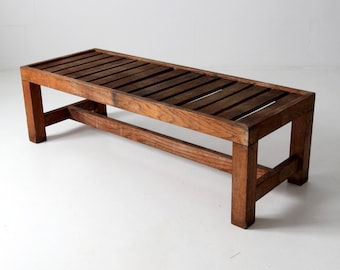

In [61]:
images[24]

#### Embedding Queries Preparation

We will use the image above as our query image and "Simple vintage wood bench" as our text query. 

Since both queries represent similar items, it will be interesting to observe the results and see how well the embedding search can match and retrieve relevant items from our collection. 

This comparison will help demonstrate the effectiveness of using both visual and textual queries within the same dataset.

In [65]:
QUERY_IMAGE_TO_EMBED = images[24]
QUERY_TEXT_TO_EMBED = "Simple vintage wood bench"

In [66]:
clip_query_text_embedding, clip_query_image_embedding = create_clip_text_and_image_embeddings(
    text_to_embed=QUERY_TEXT_TO_EMBED, 
    image_to_embed=QUERY_IMAGE_TO_EMBED
    )

#### MoreLikeThis Queries Preparation

For the `MoreLikeThis` search, we'll need to identify the document ID of the item we wish to base our search on. 

We'll use the ID of the same image previously selected for our embedding search. 

Due to the structure of our dataset, where each item is represented by two records (one for text embeddings and another for image embeddings), the index of the image has effectively doubled. Originally at index **24**, it is now at **48** and **49** to reflect this dual representation. 

Therefore, the record at index 48 corresponds to the textual representation, while the record at index 49 corresponds to the image representation of the item. 

In [67]:
unpacked_records[48]["text"]

'vintage slat wood coffee table or bench This is a vintage slat wood coffee table bench.  The table features a slat wood top with bold block legs.    CONDITIONIn good condition with wear consistent with age and use.  One of the slats is jammed at an angle. MEASUREMENTSLength:  60"  .. 152.4 cmWidth:  22"  .. 55.9 cmHeight:  18"  .. 45.7 cmSHIPPINGHome Delivery via a blanket wrap delivery service.  Delivery estimate in 4-6 weeks.  For expedited options, please contact us for pricing based on your location. International and non-contiguous US customers, please contact us for pricing and options based on your location.61917 vintage slat wood coffee table or bench Home & Living Furniture Living Room Furniture'

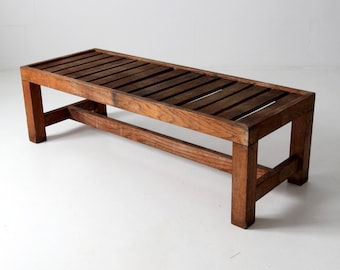

In [68]:
images_from_urls([unpacked_records[49]["text"]])[0]

In [69]:
QUERY_TEXT_DOCUMENT_ID = unpacked_records[48]["id"]
QUERY_IMAGE_DOCUMENT_ID = unpacked_records[49]["id"]

### 5.2 Search

Now that we're ready, the following cells will be dedicated to executing our search operations. 

We'll perform two embedding searches — one with a sample image and the other with a text query, and following these, we'll perform two MoreLikeThis searches over the same collection.

#### Embedding Search

- **Embedding Search** works by internally comparing the embedding query vectors with the embedding vectors stored in the collection. 

- **Vantage** handles all similarity calculations internally and returns the documents/records that are most similar to our query embedding vectors. This process efficiently identifies and ranks the records in the collection based on their relevance to the query.

In [70]:
image_embedding_results = vantage_client.embedding_search(embedding=clip_query_image_embedding, collection_id=COLLECTION_ID)
text_embedding_results = vantage_client.embedding_search(embedding=clip_query_text_embedding, collection_id=COLLECTION_ID)

#### More Like This Search

- **MoreLikeThis Search** operates similarly to the embedding search previously described, with the key difference being that instead of directly providing an embedding vector, we supply a document ID that exists within our collection. 

- **Vantage** then returns the most similar documents/records to the one specified, ranking the results based on their relevance to our query document. This approach allows for an intuitive method of finding items similar to a known reference point within the dataset.

In [71]:
more_like_this_image_results = vantage_client.more_like_this_search(document_id=QUERY_IMAGE_DOCUMENT_ID, collection_id=COLLECTION_ID)
more_like_this_text_results = vantage_client.more_like_this_search(document_id=QUERY_TEXT_DOCUMENT_ID, collection_id=COLLECTION_ID)

### 5.3 Search Results Analysis

To visualize our search results effectively, we will implement a simple helper function. 

These functions will enrich our search results with `image_url` and `image` fields for each result and then display results as image grid.

In [94]:
def enrich_search_results(search_results: vantage.SearchResult) -> tuple:
    result_dicts = [res.model_dump() for res in search_results.results]

    for res in result_dicts:
        if str(res["id"]).endswith("_text"):
            res["text"] = [record["text"] for record in unpacked_records if record["id"] == res["id"]]
            res["image_url"] = [record["text"] for record in unpacked_records if record["id"] == res["id"][:32] + "_image"]
        else:
            res["image_url"] = [record["text"] for record in unpacked_records if record["id"] == res["id"]]
        res["image"] = images_from_urls(res["image_url"])[0]

    images = [res["image"] for res in result_dicts]
    scores = [res["score"] for res in result_dicts]

    return images, scores

In [96]:
import matplotlib.pyplot as plt

def display_images_as_grid(
    images: list,
    scores: list,
    columns=5, 
    width=20, 
    height=8,):

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image, score in zip(range(len(images)), images, scores):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)
        plt.title(f"Score: {score}")

In [97]:
def display_search_results(search_results: vantage.SearchResult):
    images, scores = enrich_search_results(search_results)
    display_images_as_grid(images, scores)
        

#### Embedding Search - *Image Query Embeddings*

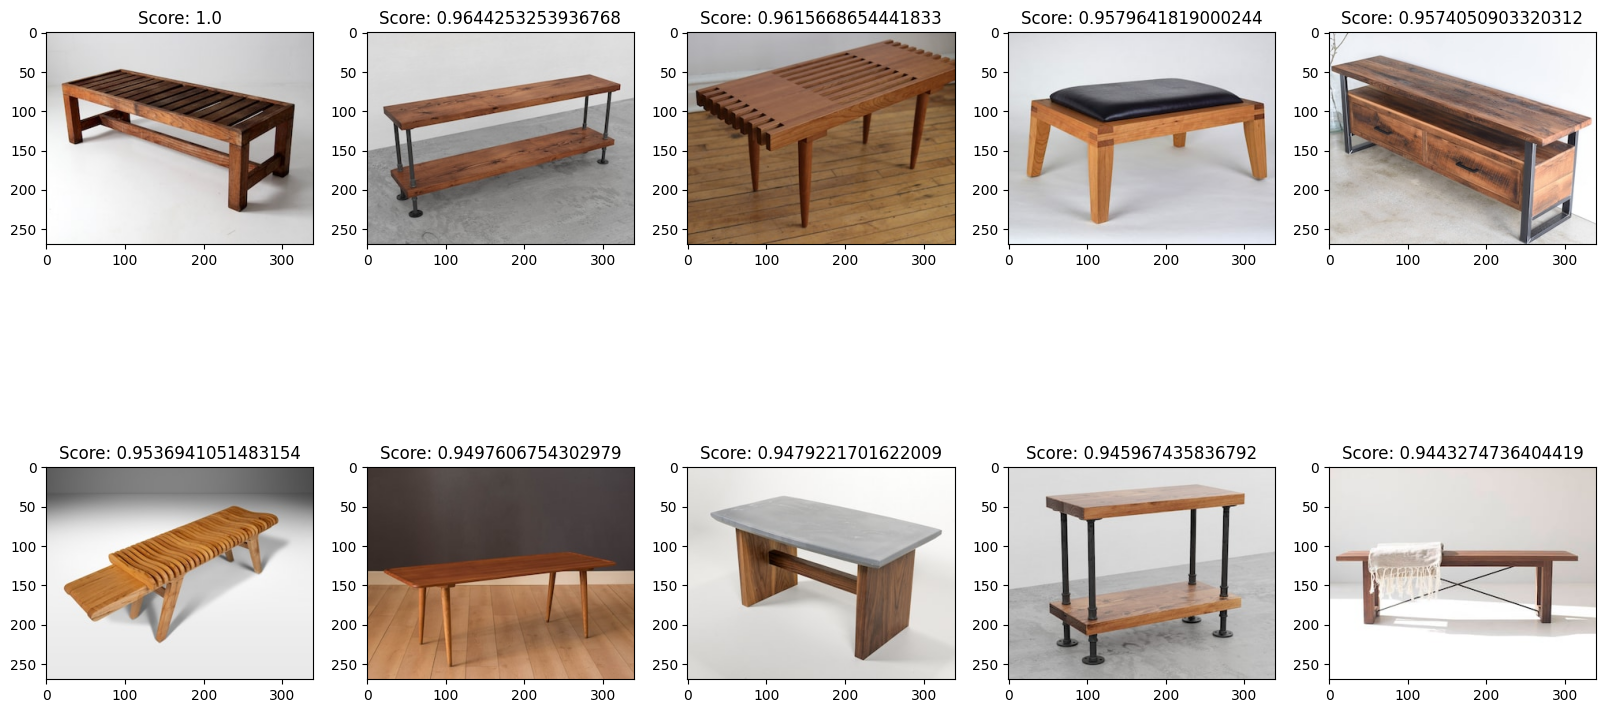

In [98]:
display_search_results(image_embedding_results)

#### Embedding Search - *Text Query Embeddings*

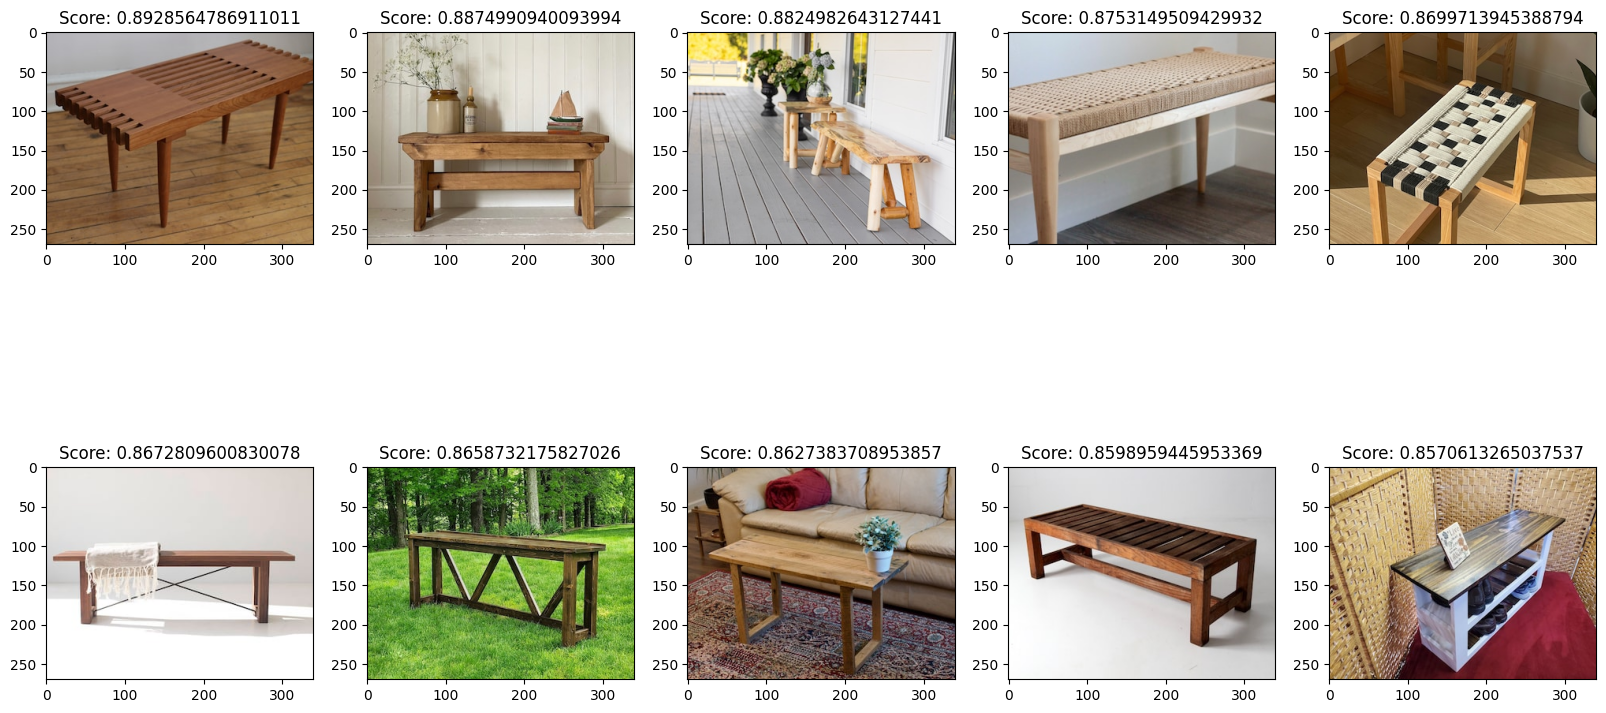

In [99]:
display_search_results(text_embedding_results)

#### More Like This Search - *Document ID with Image Embeddings*

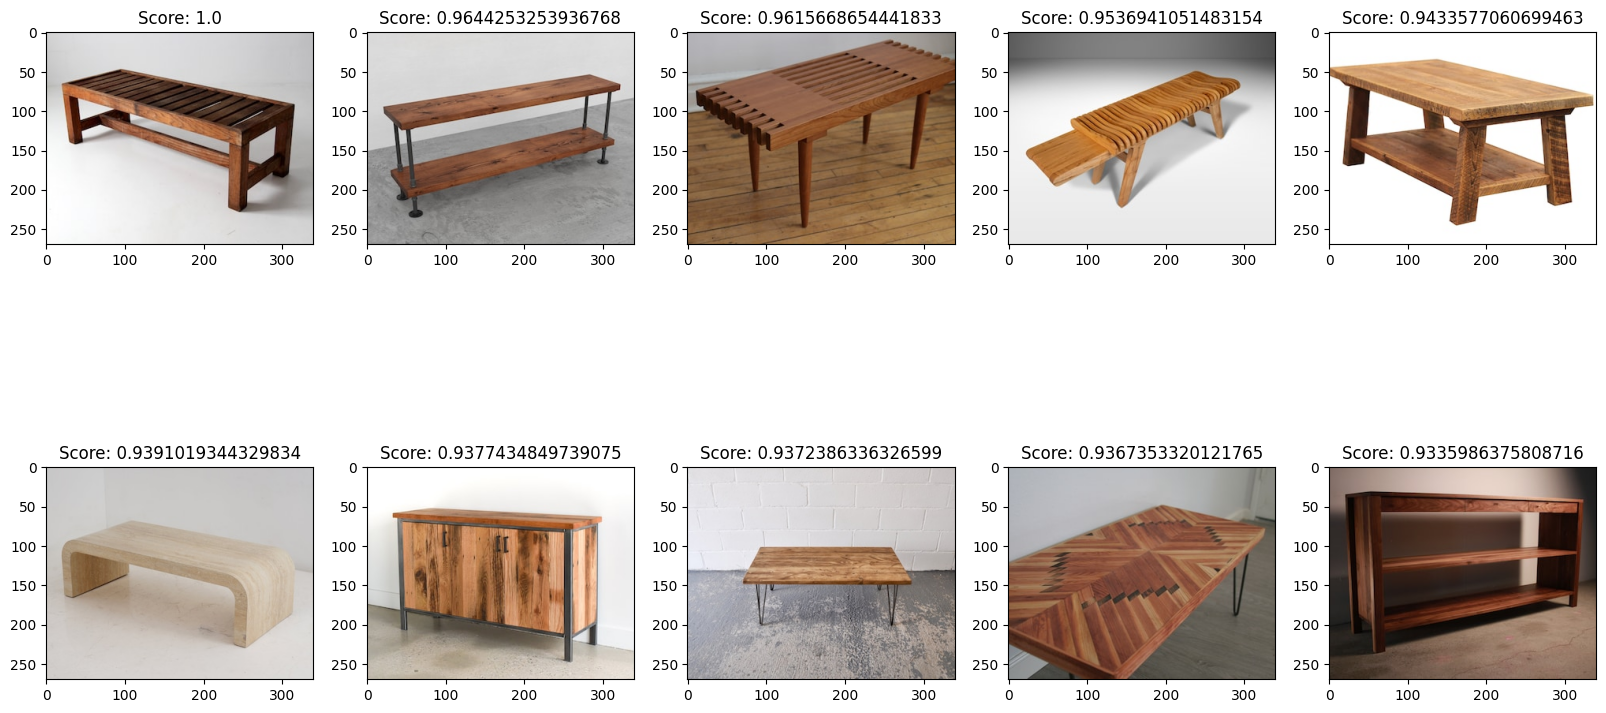

In [100]:
display_search_results(more_like_this_image_results)

#### More Like This Search - *Document ID with Text Embeddings*

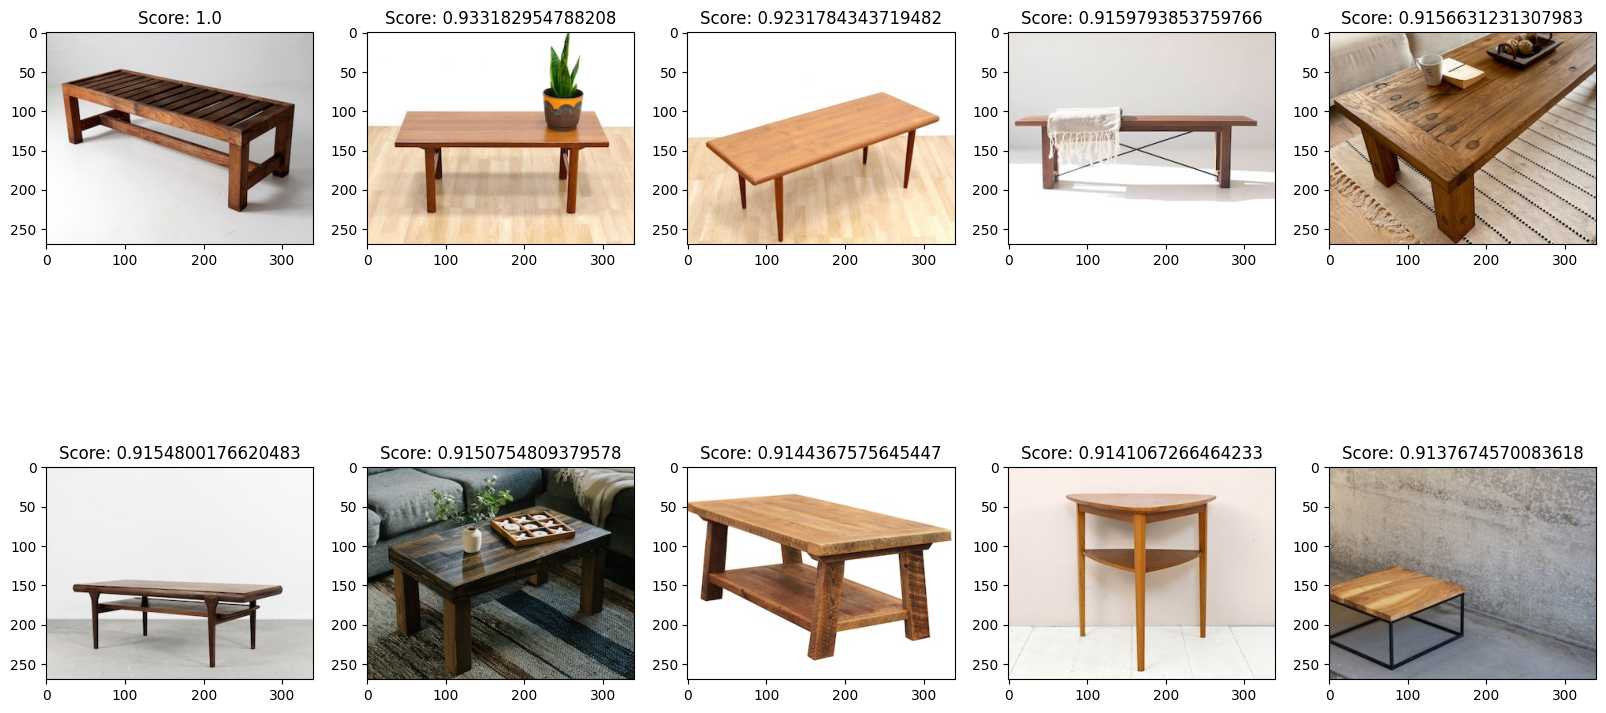

In [101]:
display_search_results(more_like_this_text_results)

## Conclusion

We can see that all of our search results returned items that are similar to our queries. 

While the results are not identical — due to the slight differences in the methods used for each search — the similarity across items effectively demonstrates the efficiency of both **Embedding** searches and **MoreLikeThis** searches. This also highlights the versatility of accepting **both text and image inputs** for queries.

We hope this tutorial has been informative and helpful to you! For further exploration and more use cases, feel free to check out our other tutorials or examples.

Happy discovering!